# Maratona DEV - Challenge 05

## Objetivo:
O desafio consiste de implementar um algoritmo de Machine Learning para classificação binária, capaz de identificar se um cliente será perdido (churn) ou não.

Link: https://github.com/maratonadev/desafio-5-2021

## 1 - Importando as bibliotecas

In [242]:
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTENC, ADASYN
from imblearn.pipeline import Pipeline as pipe

sns.set()

## 2 - Carregando as Bases de dados

In [2]:
df = pd.read_csv('datasets/dataset.csv')
df.head()

,ID,GENDER,SENIORCITIZEN,PARTNER,DEPENDENTS,TENURE,PHONESERVICE,MULTIPLELINES,INTERNETSERVICE,ONLINESECURITY,...,DEVICEPROTECTION,TECHSUPPORT,STREAMINGTV,STREAMINGMOVIES,CONTRACT,PAPERLESSBILLING,PAYMENTMETHOD,MONTHLYCHARGES,TOTALCHARGES,CHURN
0,3418,Female,0.0,No,No,26.0,Yes,No,DSL,No,...,Yes,No,No,No,Month-to-month,Yes,Credit card (automatic),131.55,1483.7,No
1,6865,Male,0.0,No,No,39.0,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Credit card (automatic),79.61,2737.31,No
2,2799,Male,0.0,No,No,1.0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Credit card (automatic),9.26,9.26,No
3,1584,Male,0.0,Yes,Yes,66.0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Credit card (automatic),42.14,1689.19,No
4,9997,Male,0.0,No,No,56.0,Yes,Yes,Fiber optic,No,...,No,No,Yes,Yes,Month-to-month,No,Electronic check,126.24,5608.69,No


In [3]:
answers = pd.read_csv('datasets/answers.csv')
answers.head()

,ID,GENDER,SENIORCITIZEN,PARTNER,DEPENDENTS,TENURE,PHONESERVICE,MULTIPLELINES,INTERNETSERVICE,ONLINESECURITY,...,DEVICEPROTECTION,TECHSUPPORT,STREAMINGTV,STREAMINGMOVIES,CONTRACT,PAPERLESSBILLING,PAYMENTMETHOD,MONTHLYCHARGES,TOTALCHARGES,CHURN
0,6946,Female,0,No,No,3,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Electronic check,51.71,90.81,TO_FILL
1,2228,Male,0,No,No,47,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),57.05,979.6,TO_FILL
2,3591,Male,0,Yes,No,62,Yes,Yes,Fiber optic,Yes,...,No,No,No,Yes,One year,No,Electronic check,235.56,6140.91,TO_FILL
3,1153,Male,0,No,Yes,1,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,142.25,142.25,TO_FILL
4,5227,Male,0,No,No,24,Yes,No,DSL,Yes,...,No,Yes,No,No,Month-to-month,No,Electronic check,105.40,1398.95,TO_FILL


## 3 - Explorando a base de dados

In [4]:
print(f'O dataset df possui {df.shape[0]} linhas e {df.shape[1]} atributos')
print(f'O dataset answers possui {answers.shape[0]} linhas e {answers.shape[1]} atributos')

O dataset df possui 4548 linhas e 21 atributos
O dataset answers possui 1324 linhas e 21 atributos


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4548 entries, 0 to 4547
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                4548 non-null   int64  
 1   GENDER            4520 non-null   object 
 2   SENIORCITIZEN     4523 non-null   float64
 3   PARTNER           4524 non-null   object 
 4   DEPENDENTS        4526 non-null   object 
 5   TENURE            4533 non-null   float64
 6   PHONESERVICE      4520 non-null   object 
 7   MULTIPLELINES     4523 non-null   object 
 8   INTERNETSERVICE   4524 non-null   object 
 9   ONLINESECURITY    4518 non-null   object 
 10  ONLINEBACKUP      4518 non-null   object 
 11  DEVICEPROTECTION  4524 non-null   object 
 12  TECHSUPPORT       4530 non-null   object 
 13  STREAMINGTV       4523 non-null   object 
 14  STREAMINGMOVIES   4523 non-null   object 
 15  CONTRACT          4525 non-null   object 
 16  PAPERLESSBILLING  4517 non-null   object 


In [6]:
df['TOTALCHARGES'].value_counts(dropna=False)[:5]

NaN        21
            3
198.57      2
980.2       2
1028.63     2
Name: TOTALCHARGES, dtype: int64

In [7]:
df['TOTALCHARGES'].replace(' ', np.nan, inplace=True)
print(df['TOTALCHARGES'].value_counts(dropna=False)[:5])
df['TOTALCHARGES'] = df['TOTALCHARGES'].astype('float')

NaN       24
105.72     2
5.75       2
695.3      2
174.67     2
Name: TOTALCHARGES, dtype: int64


In [8]:
df = df.convert_dtypes()
df['ID'] = df['ID'].astype('object')

In [9]:
df.select_dtypes('string').columns

Index(['GENDER', 'PARTNER', 'DEPENDENTS', 'PHONESERVICE', 'MULTIPLELINES',
       'INTERNETSERVICE', 'ONLINESECURITY', 'ONLINEBACKUP', 'DEVICEPROTECTION',
       'TECHSUPPORT', 'STREAMINGTV', 'STREAMINGMOVIES', 'CONTRACT',
       'PAPERLESSBILLING', 'PAYMENTMETHOD', 'CHURN'],
      dtype='object')

In [10]:
df['CHURN'] = df['CHURN'].map({'Yes': 1, 'No': 0}, na_action='ignore')
df['CHURN'].value_counts(dropna=False)

0    3337
1    1211
Name: CHURN, dtype: int64

In [11]:
df.isna().sum()[df.isna().sum() > 0].index

Index(['GENDER', 'SENIORCITIZEN', 'PARTNER', 'DEPENDENTS', 'TENURE',
       'PHONESERVICE', 'MULTIPLELINES', 'INTERNETSERVICE', 'ONLINESECURITY',
       'ONLINEBACKUP', 'DEVICEPROTECTION', 'TECHSUPPORT', 'STREAMINGTV',
       'STREAMINGMOVIES', 'CONTRACT', 'PAPERLESSBILLING', 'PAYMENTMETHOD',
       'MONTHLYCHARGES', 'TOTALCHARGES'],
      dtype='object')

In [12]:
df.dtypes

ID                   object
GENDER               string
SENIORCITIZEN         Int64
PARTNER              string
DEPENDENTS           string
TENURE                Int64
PHONESERVICE         string
MULTIPLELINES        string
INTERNETSERVICE      string
ONLINESECURITY       string
ONLINEBACKUP         string
DEVICEPROTECTION     string
TECHSUPPORT          string
STREAMINGTV          string
STREAMINGMOVIES      string
CONTRACT             string
PAPERLESSBILLING     string
PAYMENTMETHOD        string
MONTHLYCHARGES      Float64
TOTALCHARGES        Float64
CHURN                 int64
dtype: object

In [13]:
categorical_columns = df.select_dtypes('string').columns
float_columns = ['MONTHLYCHARGES', 'TOTALCHARGES']
int_columns = ['SENIORCITIZEN', 'TENURE']

In [14]:
df['CHURN'].value_counts(normalize=True)

0    0.733729
1    0.266271
Name: CHURN, dtype: float64

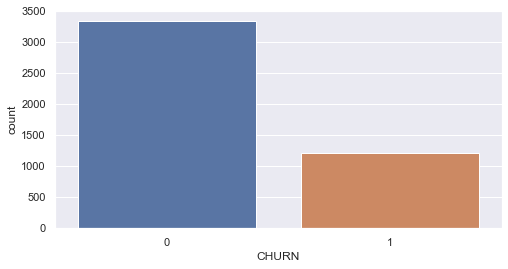

In [15]:
fig, ax = plt.subplots(figsize=(8,4))
sns.countplot(x='CHURN', data=df, ax=ax)
plt.show()

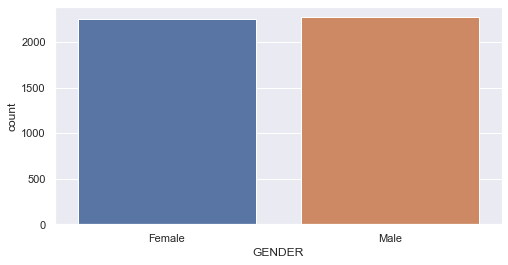

In [16]:
fig, ax = plt.subplots(figsize=(8,4))
sns.countplot(x='GENDER', data=df, ax=ax)
plt.show()

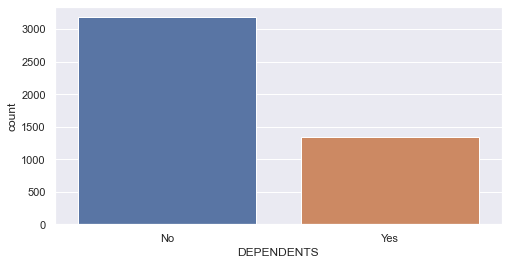

In [17]:
fig, ax = plt.subplots(figsize=(8,4))
sns.countplot(x='DEPENDENTS', data=df, ax=ax)
plt.show()

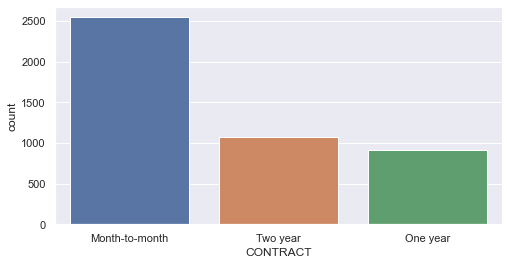

In [18]:
fig, ax = plt.subplots(figsize=(8,4))
sns.countplot(x='CONTRACT', data=df, ax=ax)
plt.show()

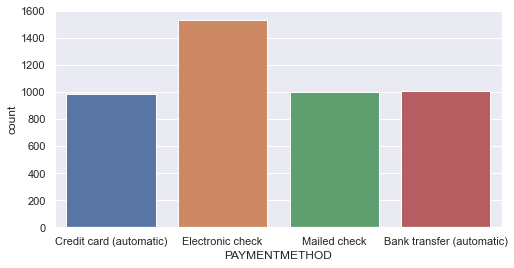

In [19]:
fig, ax = plt.subplots(figsize=(8,4))
sns.countplot(x='PAYMENTMETHOD', data=df, ax=ax)
plt.show()

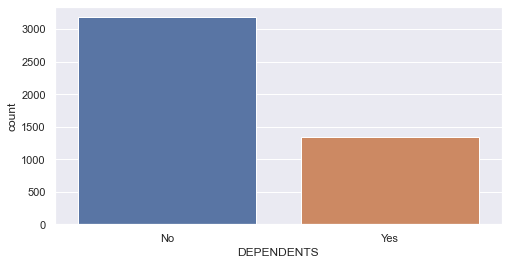

In [20]:
fig, ax = plt.subplots(figsize=(8,4))
sns.countplot(x='DEPENDENTS', data=df, ax=ax)
plt.show()

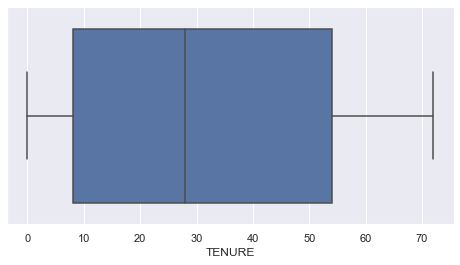

In [21]:
fig, ax = plt.subplots(figsize=(8,4))
sns.boxplot(x='TENURE', data=df, ax=ax)
plt.show()

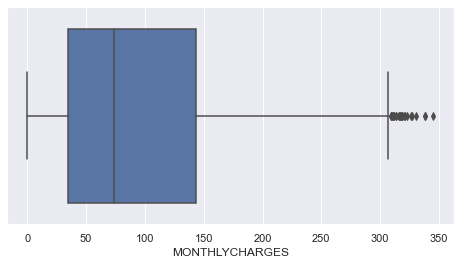

In [22]:
fig, ax = plt.subplots(figsize=(8,4))
sns.boxplot(x='MONTHLYCHARGES', data=df, ax=ax)
plt.show()

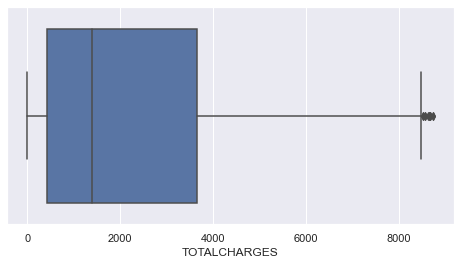

In [23]:
fig, ax = plt.subplots(figsize=(8,4))
sns.boxplot(x='TOTALCHARGES', data=df, ax=ax)
plt.show()

In [24]:
df.isna().sum()

ID                   0
GENDER              28
SENIORCITIZEN       25
PARTNER             24
DEPENDENTS          22
TENURE              15
PHONESERVICE        28
MULTIPLELINES       25
INTERNETSERVICE     24
ONLINESECURITY      30
ONLINEBACKUP        30
DEVICEPROTECTION    24
TECHSUPPORT         18
STREAMINGTV         25
STREAMINGMOVIES     25
CONTRACT            23
PAPERLESSBILLING    31
PAYMENTMETHOD       28
MONTHLYCHARGES      21
TOTALCHARGES        24
CHURN                0
dtype: int64

In [25]:
for col in categorical_columns:
    print(df[col].value_counts(dropna=False))

Male      2271
Female    2249
NaN         28
Name: GENDER, dtype: Int64
No     2319
Yes    2205
NaN      24
Name: PARTNER, dtype: Int64
No     3183
Yes    1343
NaN      22
Name: DEPENDENTS, dtype: Int64
Yes    4110
No      410
NaN      28
Name: PHONESERVICE, dtype: Int64
No                  2218
Yes                 1897
No phone service     408
NaN                   25
Name: MULTIPLELINES, dtype: Int64
Fiber optic    1996
DSL            1534
No              994
NaN              24
Name: INTERNETSERVICE, dtype: Int64
No                     2258
Yes                    1264
No internet service     996
NaN                      30
Name: ONLINESECURITY, dtype: Int64
No                     2009
Yes                    1514
No internet service     995
NaN                      30
Name: ONLINEBACKUP, dtype: Int64
No                     1985
Yes                    1545
No internet service     994
NaN                      24
Name: DEVICEPROTECTION, dtype: Int64
No                     2240
Yes      

## 4 - Modelo de ML

In [82]:
df.replace({pd.NA: np.nan}, inplace=True)
#df = df.convert_dtypes()

In [68]:
df.dtypes

ID                    int64
GENDER               object
SENIORCITIZEN       Float64
PARTNER              object
DEPENDENTS           object
TENURE              Float64
PHONESERVICE         object
MULTIPLELINES        object
INTERNETSERVICE      object
ONLINESECURITY       object
ONLINEBACKUP         object
DEVICEPROTECTION     object
TECHSUPPORT          object
STREAMINGTV          object
STREAMINGMOVIES      object
CONTRACT             object
PAPERLESSBILLING     object
PAYMENTMETHOD        object
MONTHLYCHARGES       object
TOTALCHARGES         object
CHURN                 int64
dtype: object

In [83]:
X = df.drop(['ID', 'CHURN'], axis=1)
y = df['CHURN'].copy()

### 4.1 - Modelo Dummy

#### 4.11 - Modelo Dummy - Most frequent

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

dummy_most_frequent = DummyClassifier(strategy='most_frequent', random_state=42)
dummy_most_frequent.fit(X_train, y_train.values.ravel())
y_pred = dummy_most_frequent.predict(X_test)
score = f1_score(y_test, y_pred)
print(f'O score do modelo dummy most frequent é: {score}')

O score do modelo dummy most frequent é: 0.0


#### 4.12 - Modelo Dummy - stratified

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

dummy_stratified = DummyClassifier(strategy='stratified', random_state=42)
dummy_stratified.fit(X_train, y_train)
y_pred = dummy_stratified.predict(X_test)
score = f1_score(y_test, y_pred)
print(f'O score do modelo dummy most frequent é: {score}')

O score do modelo dummy most frequent é: 0.257328990228013


### 4.2 - Pipeline

In [33]:
categorical_columns = ['GENDER', 'PARTNER', 'DEPENDENTS', 'PHONESERVICE', 'MULTIPLELINES',
       'INTERNETSERVICE', 'ONLINESECURITY', 'ONLINEBACKUP',
       'DEVICEPROTECTION', 'TECHSUPPORT', 'STREAMINGTV',
       'STREAMINGMOVIES', 'CONTRACT', 'PAPERLESSBILLING', 'PAYMENTMETHOD']

In [112]:
cat_trans = Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                            ('encoder', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

float_trans = Pipeline(steps=[('impute', SimpleImputer(strategy='mean')),
                              ('scaler', StandardScaler())])

int_trans = Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler())])

columns_transformation = ColumnTransformer([('cat', cat_trans, categorical_columns),
                                            ('float', float_trans, float_columns),
                                            ('int', int_trans, int_columns)])

pipeline = Pipeline(steps=[('transformation', columns_transformation),
                           ('selectFeatures', SelectKBest()),
                           ('clf', DecisionTreeClassifier())])

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

pipeline.fit(X_train, y_train.values)
y_pred = pipeline.predict(X_test)
score = f1_score(y_test, y_pred)
print(f'O score do modelo dummy most frequent é: {score}')

O score do modelo dummy most frequent é: 0.5138211382113822


### 4.3 - Escolhendo o melhor modelo

In [160]:
cat_trans = Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                            ('encoder', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

float_trans = Pipeline(steps=[('impute', SimpleImputer(strategy='mean')),
                              ('scaler', StandardScaler())])

int_trans = Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler())])

columns_transformation = ColumnTransformer([('cat', cat_trans, categorical_columns),
                                            ('float', float_trans, float_columns),
                                            ('int', int_trans, int_columns)])

pipeline = Pipeline(steps=[('transformation', columns_transformation),
                           ('selectFeatures', SelectKBest()),
                           ('clf', DecisionTreeClassifier())])

In [161]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

pipeline.fit(X_train, y_train.values)
y_pred = pipeline.predict(X_test)
score = f1_score(y_test, y_pred)
print(f'O score do modelo é: {score}')

O score do modelo é: 0.5057096247960848


In [165]:
model1 = AdaBoostClassifier()
model2 = BaggingClassifier()
model3 = ExtraTreesClassifier()
model4 = GradientBoostingClassifier()
model5 = RandomForestClassifier()
model6 = HistGradientBoostingClassifier()

In [166]:
lista_modelos = [model1, model2, model3, model4, model5, model6]

In [167]:
def comparando_modelos(lista_modelos):
    for modelo in lista_modelos:
        cat_trans = Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                                ('encoder', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

        float_trans = Pipeline(steps=[('impute', SimpleImputer(strategy='mean')),
                                      ('scaler', StandardScaler())])

        int_trans = Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                                    ('scaler', StandardScaler())])

        columns_transformation = ColumnTransformer([('cat', cat_trans, categorical_columns),
                                                    ('float', float_trans, float_columns),
                                                    ('int', int_trans, int_columns)])

        pipeline = Pipeline(steps=[('transformation', columns_transformation),
                                   ('selectFeatures', SelectKBest()),
                                   ('clf', modelo)])

        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

        pipeline.fit(X_train, y_train.values.ravel())
        y_pred = pipeline.predict(X_test)
        score = f1_score(y_test, y_pred)
        print(f'O score do modelo {str(modelo)} é: {score}')    

In [168]:
comparando_modelos(lista_modelos)

O score do modelo AdaBoostClassifier() é: 0.5424354243542435
O score do modelo BaggingClassifier() é: 0.5284280936454848
O score do modelo ExtraTreesClassifier() é: 0.5188834154351396
O score do modelo GradientBoostingClassifier() é: 0.5617173524150268
O score do modelo RandomForestClassifier() é: 0.5165562913907286
O score do modelo HistGradientBoostingClassifier() é: 0.5505226480836237


### 4.4 - Tunando os hiper parametros

In [201]:
param_GradientBoostingClassifier = {'selectFeatures__k': np.arange(10, 40, 1),
                                    'clf__min_samples_split': np.arange(2, 100, 2),
                                    'clf__min_samples_leaf': np.arange(1, 50, 1),
                                    'clf__max_depth': np.arange(2, 20, 1),
                                    'clf__learning_rate': np.arange(0.01, 0.2, 0.01)}

In [202]:
cat_trans = Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                            ('encoder', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

float_trans = Pipeline(steps=[('impute', SimpleImputer(strategy='mean')),
                              ('scaler', StandardScaler())])

int_trans = Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler())])

columns_transformation = ColumnTransformer([('cat', cat_trans, categorical_columns),
                                            ('float', float_trans, float_columns),
                                            ('int', int_trans, int_columns)])

pipeline_GradientBoostingClassifier = Pipeline(steps=[('transformation', columns_transformation),
                                                      ('selectFeatures', SelectKBest()),
                                                      ('clf', GradientBoostingClassifier())])

In [203]:
search_GradientBoostingClassifier = RandomizedSearchCV(pipeline_GradientBoostingClassifier, 
                                                       param_GradientBoostingClassifier, 
                                                       cv=5, scoring='f1', n_iter=30)

search_GradientBoostingClassifier.fit(X, y)
print(search_GradientBoostingClassifier.best_score_)

0.586328339241226


In [218]:
param_HistGradientBoostingClassifier = {'selectFeatures__k': np.arange(10, 40, 1),
                                        'clf__max_leaf_nodes': np.arange(20, 150, 2),
                                        'clf__min_samples_leaf': np.arange(1, 50, 1),
                                        'clf__max_depth': np.arange(2, 20, 1),
                                        'clf__learning_rate': np.arange(0.01, 0.2, 0.01)}

In [219]:
cat_trans = Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                            ('encoder', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

float_trans = Pipeline(steps=[('impute', SimpleImputer(strategy='mean')),
                              ('scaler', StandardScaler())])

int_trans = Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler())])

columns_transformation = ColumnTransformer([('cat', cat_trans, categorical_columns),
                                            ('float', float_trans, float_columns),
                                            ('int', int_trans, int_columns)])

pipeline_HistGradientBoostingClassifier = Pipeline(steps=[('transformation', columns_transformation),
                                                          ('selectFeatures', SelectKBest()),
                                                          ('clf', HistGradientBoostingClassifier())])

In [220]:
search_HistGradientBoostingClassifier = RandomizedSearchCV(pipeline_HistGradientBoostingClassifier, 
                                                           param_HistGradientBoostingClassifier, 
                                                           cv=5, scoring='f1', n_iter=30)

search_HistGradientBoostingClassifier.fit(X, y)
print(search_HistGradientBoostingClassifier.best_score_)

0.5906785248930264


### 4.5 - Over-sampling

In [251]:
param_HistGradientBoostingClassifier = {'selectFeatures__k': np.arange(10, 40, 1),
                                        'clf__max_leaf_nodes': np.arange(20, 150, 2),
                                        'clf__min_samples_leaf': np.arange(1, 50, 1),
                                        'clf__max_depth': np.arange(2, 20, 1),
                                        'clf__learning_rate': np.arange(0.01, 0.2, 0.01)}

In [252]:
cat_trans = Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                            ('encoder', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

float_trans = Pipeline(steps=[('impute', SimpleImputer(strategy='mean')),
                              ('scaler', StandardScaler())])

int_trans = Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler())])

columns_transformation = ColumnTransformer([('cat', cat_trans, categorical_columns),
                                            ('float', float_trans, float_columns),
                                            ('int', int_trans, int_columns)])

pipeline_HistGradientBoostingClassifier = Pipeline(steps=[('selectFeatures', SelectKBest()),
                                                          ('clf', HistGradientBoostingClassifier())])

In [253]:
X_resampled, y_resampled = SMOTE().fit_resample(columns_transformation.fit_transform(X), y)
print(y_resampled.value_counts(normalize=True))

search_HistGradientBoostingClassifier = RandomizedSearchCV(pipeline_HistGradientBoostingClassifier, 
                                                           param_HistGradientBoostingClassifier, 
                                                           cv=5, scoring='f1', n_iter=30)

search_HistGradientBoostingClassifier.fit(X_resampled, y_resampled)
print(search_HistGradientBoostingClassifier.best_score_)

0    0.5
1    0.5
Name: CHURN, dtype: float64
0.8357618530535177


In [254]:
param_GradientBoostingClassifier = {'selectFeatures__k': np.arange(10, 40, 1),
                                    'clf__min_samples_split': np.arange(2, 100, 2),
                                    'clf__min_samples_leaf': np.arange(1, 50, 1),
                                    'clf__max_depth': np.arange(2, 20, 1),
                                    'clf__learning_rate': np.arange(0.01, 0.2, 0.01)}

In [255]:
cat_trans = Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                            ('encoder', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

float_trans = Pipeline(steps=[('impute', SimpleImputer(strategy='mean')),
                              ('scaler', StandardScaler())])

int_trans = Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler())])

columns_transformation = ColumnTransformer([('cat', cat_trans, categorical_columns),
                                            ('float', float_trans, float_columns),
                                            ('int', int_trans, int_columns)])

pipeline_GradientBoostingClassifier = Pipeline(steps=[('selectFeatures', SelectKBest()),
                                                          ('clf', GradientBoostingClassifier())])

In [256]:
X_resampled, y_resampled = SMOTE().fit_resample(columns_transformation.fit_transform(X), y)
print(y_resampled.value_counts(normalize=True))

search_GradientBoostingClassifier = RandomizedSearchCV(pipeline_GradientBoostingClassifier, 
                                                           param_HistGradientBoostingClassifier, 
                                                           cv=5, scoring='f1', n_iter=30)

search_GradientBoostingClassifier.fit(X_resampled, y_resampled)
print(search_GradientBoostingClassifier.best_score_)

0    0.5
1    0.5
Name: CHURN, dtype: float64
0.8308093699740422


### 4.6 - Melhor modelo

In [257]:
melhor_modelo = search_HistGradientBoostingClassifier.best_estimator_

## 5 - Classificando os dados do answers

In [267]:
answers_df = answers.copy()
answers_df['TOTALCHARGES'].replace(' ', np.nan, inplace=True)

In [279]:
X_answers = answers_df.drop(['ID'], axis=1)

answers['CHURN'] = melhor_modelo.predict(columns_transformation.transform(X_answers))
answers['CHURN'] = answers['CHURN'].map({0: 'No', 1: 'Yes'})
answers.head()

,ID,GENDER,SENIORCITIZEN,PARTNER,DEPENDENTS,TENURE,PHONESERVICE,MULTIPLELINES,INTERNETSERVICE,ONLINESECURITY,...,DEVICEPROTECTION,TECHSUPPORT,STREAMINGTV,STREAMINGMOVIES,CONTRACT,PAPERLESSBILLING,PAYMENTMETHOD,MONTHLYCHARGES,TOTALCHARGES,CHURN
0,6946,Female,0,No,No,3,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Electronic check,51.71,90.81,No
1,2228,Male,0,No,No,47,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),57.05,979.6,No
2,3591,Male,0,Yes,No,62,Yes,Yes,Fiber optic,Yes,...,No,No,No,Yes,One year,No,Electronic check,235.56,6140.91,No
3,1153,Male,0,No,Yes,1,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,142.25,142.25,Yes
4,5227,Male,0,No,No,24,Yes,No,DSL,Yes,...,No,Yes,No,No,Month-to-month,No,Electronic check,105.40,1398.95,No


In [280]:
answers['CHURN'].value_counts(normalize=True)

No     0.746224
Yes    0.253776
Name: CHURN, dtype: float64

In [282]:
answers.to_csv('datasets/answers_done.csv', index=False)

In [283]:
answers_done = pd.read_csv('datasets/answers_done.csv')
answers_done.head()

,ID,GENDER,SENIORCITIZEN,PARTNER,DEPENDENTS,TENURE,PHONESERVICE,MULTIPLELINES,INTERNETSERVICE,ONLINESECURITY,...,DEVICEPROTECTION,TECHSUPPORT,STREAMINGTV,STREAMINGMOVIES,CONTRACT,PAPERLESSBILLING,PAYMENTMETHOD,MONTHLYCHARGES,TOTALCHARGES,CHURN
0,6946,Female,0,No,No,3,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Electronic check,51.71,90.81,No
1,2228,Male,0,No,No,47,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),57.05,979.6,No
2,3591,Male,0,Yes,No,62,Yes,Yes,Fiber optic,Yes,...,No,No,No,Yes,One year,No,Electronic check,235.56,6140.91,No
3,1153,Male,0,No,Yes,1,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,142.25,142.25,Yes
4,5227,Male,0,No,No,24,Yes,No,DSL,Yes,...,No,Yes,No,No,Month-to-month,No,Electronic check,105.40,1398.95,No
